# Amazon Product Review Statistical Analysis

This Jupyter notebook aims at understanding the connection of product and user rating for electronic products in Amazon. The data is taken from Kaggle. I will try to analyze the statistical features of the data and then proceed to build a simple recommendation system.

Data obtained from

https://www.kaggle.com/saurav9786/amazon-product-reviews

Written by Shing Chi Leung at 19 March 2021

In [31]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

import seaborn

In [4]:
from google.colab import drive
drive.mount("gdrive")

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [5]:
df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/amazon_ratings.csv", header=None)

In [6]:
print(df.head(5))

                0          1  2           3
0   AKM1MP6P0OYPR  132793040  5  1365811200
1  A2CX7LUOHB2NDG  321732944  5  1341100800
2  A2NWSAGRHCP8N5  439886341  1  1367193600
3  A2WNBOD3WNDNKT  439886341  3  1374451200
4  A1GI0U4ZRJA8WN  439886341  1  1334707200


## Data Preprocessing

From the given DataFrame, I need to rename the columns and remove the "time" column as it is irrelevant to my study. Then I encode the ID and Product columns by ordinal number for easier management. 

In [7]:
df.rename(columns={0:"id",1:"product",2:"rating",3:"time"}, inplace=True)
print(df.head(5))

               id    product  rating        time
0   AKM1MP6P0OYPR  132793040       5  1365811200
1  A2CX7LUOHB2NDG  321732944       5  1341100800
2  A2NWSAGRHCP8N5  439886341       1  1367193600
3  A2WNBOD3WNDNKT  439886341       3  1374451200
4  A1GI0U4ZRJA8WN  439886341       1  1334707200


In [8]:
df.drop("time", axis=1, inplace=True)

d = defaultdict(LabelEncoder)
X = df.apply(lambda x:d[x.name].fit_transform(x))
print(X)

             id  product  rating
0        697756        9       4
1        283194       85       4
2        346430      100       0
3        396487      100       2
4         95545      100       0
...         ...      ...     ...
1048571   98698    61893       4
1048572   70152    61893       4
1048573  321616    61893       4
1048574  327085    61893       3
1048575   94280    61893       1

[1048576 rows x 3 columns]


### Statistics of the Review Data

Text(0, 0.5, 'Count')

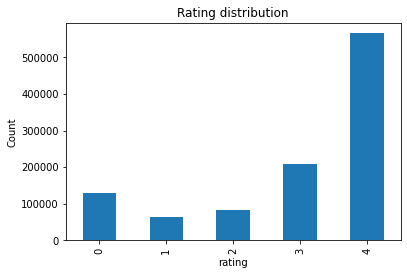

In [41]:
ax0 = X.groupby("rating")["id"].count().plot.bar()
ax0.set_title("Rating distribution")
ax0.set_ylabel("Count")

The majority of reviews are good as they get a ranking of 4 (i.e. 5 in the nominal unit).

In [8]:
print("Number of unique ID: {}".format(len(X["id"].unique())))
print("Number of unique product: {}".format(len(X["product"].unique())))

Number of unique ID: 786330
Number of unique product: 61894


In [9]:
X_product_group = X.groupby("product")

product = []
count = []
for name, group in X_product_group:
  product.append(name)
  count.append(group.shape[0])

X_product_cnt = pd.DataFrame(data={"product":product, "count":count})
X_product_cnt.sort_values(by="count", ascending=False, inplace=True)  
print(X_product_cnt)

       product  count
30276    30276   9487
24439    24439   5345
61285    61285   4903
46504    46504   4275
14183    14183   3523
...        ...    ...
14006    14006      1
14008    14008      1
14009    14009      1
37568    37568      1
31478    31478      1

[61894 rows x 2 columns]


By grouping the data as above, we can see which products are the most popular and received the most reviews in the record. 

Text(0, 0.5, 'Number of ratings')

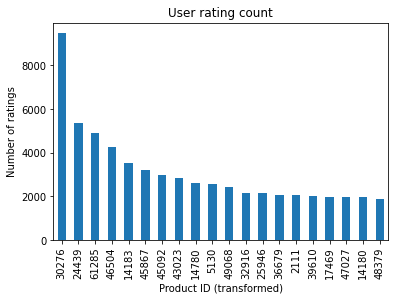

In [32]:
ax1 = X_product_cnt["count"].head(20).plot.bar()
ax1.set_title("User rating count")
ax1.set_xlabel("Product ID (transformed)")
ax1.set_ylabel("Number of ratings")

We can also examine the distribution of ranting. We observe that a lot of product received unique rating (all 2, 3 or 4). And a smaller group receives a mixed rating. 

Text(0.5, 0, 'Average rating')

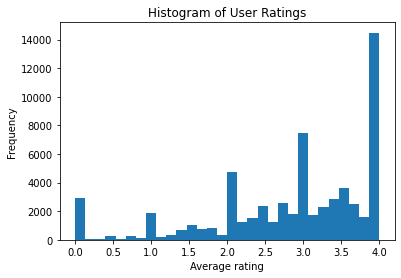

In [10]:
X_rating_mean = X.groupby("product")["rating"].mean()
ax2 = X_rating_mean.plot.hist(by="rating", bins=30)
ax2.set_title("Histogram of User Ratings")
ax2.set_xlabel("Average rating")

## Recommendation System

Now we want to do the operation to the DataFrame by including only products with more than 500 reviews and an average rating of 3 or above. This will largely minimize the parameter space such that the later recommedation system becomes possible by a single machine.

In [23]:
X_product_stat = X_product_cnt.merge(X_rating_mean, on="product", how="left")

X_product_stat = X_product_stat[X_product_stat["count"] > 500] 
X_product_stat = X_product_stat[X_product_stat["rating"] >= 3.0]
print(X_product_stat.shape)

# get the product list which receive at least 100 reviews
X_highreview_list = X_product_stat["product"].to_list()

# Filter the primitive X DF
X_short = X[X["product"].isin(X_highreview_list)]
print(X_short.shape)

(140, 3)
(155497, 3)


Now, we want to build the pivot table, which is a relation table of a given product and the comments by different users. 

In [24]:
review_matrix = X_short.pivot_table(values="rating", index="id", columns="product")
print(review_matrix.head())

product  310    2111   2248   2963   3268   ...  60512  60773  60887  61810  61889
id                                          ...                                   
4          NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
8          NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
16         NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
19         NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
34         NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN

[5 rows x 140 columns]


In [27]:
review_matrix = review_matrix.fillna(0).T

We use TruncatedSVD instead of PCA because there is no centroid of the data. All items are naturally equal. We use TruncatedSVD to find the reduced dimension of these products by a lower dimensional vector (10 dimension).

In [28]:
SVD = TruncatedSVD(n_components=10, n_iter=10)
decomposed_matrix = SVD.fit_transform(review_matrix)
decomposed_matrix.shape

(140, 10)

In [39]:
correlation_matrix = np.corrcoef(decomposed_matrix)
print(correlation_matrix.shape)

(140, 140)


### Real recommendation

Now we can use the above framework to predict the closest items which are popular and are avabilable to be promoted. But we need to do a mapping from the correlation matrix to the encoded ID. 

In [34]:
# get index 

index_list = list(review_matrix.index)

# query
query_id = 30276
query_idx = index_list.index(query_id)
print("ID {} cooresponds to {}".format(query_id, query_idx))

ID 30276 cooresponds to 63


In [44]:
print("Recommendation in the codified ")
print("Selected Item {}".format(query_id))
print("Item, Correlation")
for i in range(correlation_matrix[query_idx].shape[0]):
  if i == query_idx: continue
  if correlation_matrix[query_idx][i] > 0.6:
    print("{}: {:.2}".format(index_list[i], correlation_matrix[query_idx][i]))

Recommendation in the codified 
Selected Item 30276
Item, Correlation
4665: 0.61
10019: 0.84
30460: 0.98
31097: 0.8
36666: 0.88
38724: 0.67
43220: 0.61
52283: 0.76
60887: 0.71


The ID is encoded during early processing. The final step is to convert it back to the primitive product ID so that we can connect to the real product. 

In [49]:
print("Representation in the original ID space")
print("Selected Item {}".format(d["id"].inverse_transform([query_id])))
print("Product ID, Correlation")
for i in range(correlation_matrix[query_idx].shape[0]):
  if i == query_idx: continue
  if correlation_matrix[query_idx][i] > 0.6:
    print("{}: {:.2}".format(*d["id"].inverse_transform([index_list[i]]), correlation_matrix[query_idx][i]))

Representation in the original ID space
Selected Item ['A156OB1J0HQUQW']
Product ID, Correlation
A10QTRDCSTU1GQ: 0.61
A11O5PS9MKOGQ9: 0.84
A157VR83HRR42S: 0.98
A15BTRENLM1H21: 0.8
A16ANZRC04LAT5: 0.88
A16N6H1RGP6FKP: 0.67
A17EYHFW9EHZHB: 0.61
A18ZQZK0XINFYR: 0.76
A1AGZ9MHPHBN55: 0.71
